In [7]:
import numpy as np
from scipy.optimize import fsolve
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from paretoset import paretoset
from pymoo.indicators.gd import GD
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD

In [2]:
# Import grid search data
gridsearchdata = np.load('ARneg_SensitivityPareto.npy')

In [3]:
#Sensitivity wrt α
def S_alpha_xss_analytic(xss, alpha, n):
    numer = alpha * (1 + xss**n)
    denom = xss + alpha * n * xss**n + 2 * xss**(1+n) + xss**(1+2*n)
    sensitivity = numer/denom
    return abs(sensitivity)

#Sensitivity wrt n
def S_n_xss_analytic(xss, alpha, n):
    numer = alpha * n * np.log(xss) * xss**(n-1)
    denom = 1 + alpha * n * xss**(n-1) + 2 * xss**(n) + xss**(2*n)
    sensitivity = - numer/denom
    return abs(sensitivity)

In [4]:
#Equation: dx/dt = α/(1 + x^n) - x
def Equ1(x, alpha, n):
    return (alpha / (1 + x**n)) - x

#Wrapper function for the ODE system to be compatible with scipy's fsolve
def Equs(x, t, params):
    alpha, n = params
    return np.array([Equ1(x[0], alpha, n)])

In [ ]:
#Initial guesses
def generate_initial_guesses(alpha_val, n_val):
    return [np.array([2.0]), np.array([0.5]), np.array([4.627])]

#Steady state finder: finds one steady state given parameters (α, n)
def ssfinder(alpha_val, n_val):

    # Pack parameters into an array
    params = np.array([alpha_val, n_val])

    # Try multiple initial guesses to find steady states
    for guess in generate_initial_guesses(alpha_val, n_val):

        # Find root of the equation (where dx/dt = 0)
        xss, info, flag, _ = fsolve(Equs, guess, args=(0.0, params), full_output=True, xtol=1e-12)

        # Check if solution is valid, positive, and precise
        if (flag == 1 and xss[0] > 0.04 and np.linalg.norm(info["fvec"]) < 1e-10):
            # Check stability using numerical derivative
            d = 1e-8  # Small perturbation
            jac = (Equs(xss + d, 0.0, params) - Equs(xss, 0.0, params)) / d
            if np.real(jac)[0] < 0: # Negative Jacobian indicates stable steady state
                return xss[0]

    # Return NaN if no stable steady state found
    return np.nan

In [6]:
# Define the multi-objective optimization problem

class Sensitivity(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,                    # Number of decision variables (alpha, n)
            n_obj=2,                    # Number of objectives to minimize (S_alpha, S_n)
            n_constr=0,                 # Number of explicit constraints aside the bounds of alpha and n
            xl=np.array([0.01, 0.01]),  # Lower bounds for [alpha, n]
            xu=np.array([50.0, 10.0]))  # Upper bounds for [alpha, n]

    def _evaluate(self, x, out, *args, **kwargs):

        # Unpack decision variables (ie. parameters)
        alpha, n = x

        # Find the steady state for these parameters
        xss = ssfinder(alpha, n)

        if np.isnan(xss):
            # Penalize parameter combinations that don't yield a stable steady state
            out["F"] = [1e5, 1e5]
        else:
            # Calculate both sensitivity measures for this parameter set
            out["F"] = [
                S_alpha_xss_analytic(xss, alpha, n),
                S_n_xss_analytic(xss, alpha, n)]

Run for varying population sizes and fixed number of generations

In [7]:
# --- Parameter sweeps ---
popsize_list = np.exp(np.linspace(np.log(1), np.log(5000), num=21)).astype(int)
gens_list = np.exp(np.linspace(np.log(1), np.log(500), num=11)).astype(int)

# Storage structure:
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │            gen_1     gen_2     gen_3   ...    │
# ├───────────────────────────────────────────────┤
# │ pop_1     [None]    [None]    [None]   ...    │
# │ pop_2     [None]    [None]    [None]   ...    │
# │ pop_3     [None]    [None]    [None]   ...    │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘
all_F = [[None for _ in gens_list] for _ in popsize_list]
all_X = [[None for _ in gens_list] for _ in popsize_list]
all_time = np.zeros((len(popsize_list), len(gens_list)))
all_size = np.zeros((len(popsize_list), len(gens_list)), dtype=int)

# --- Optimization loops ---
for i, popsize in enumerate(popsize_list):
    for j, gens in enumerate(gens_list):

        algorithm = NSGA2(pop_size=int(popsize))

        res = minimize(
            Sensitivity(),        # your optimization problem
            algorithm,            # algorithm instance
            ('n_gen', int(gens)), # number of generations as stopping criterion
            seed=1,               # reproducibility
            verbose=False)

        # Store results in grid form
        all_F[i][j] = res.F
        all_X[i][j] = res.X
        all_time[i, j] = res.exec_time
        all_size[i, j] = res.F.shape[0]

        print(f"Finished run: population = {popsize:5d}, generations = {gens:4d}  (time: {res.exec_time:.2f}s)")

# Our final all_F and all_X structures
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │         gen_1     gen_2     gen_3   ...       │
# ├───────────────────────────────────────────────┤
# │ pop_1  [F[0][0]] [F[0][1]] [F[0][2]] ...      │
# │ pop_2  [F[1][0]] [F[1][1]] [F[1][2]] ...      │
# │ pop_3  [F[2][0]] [F[2][1]] [F[2][2]] ...      │
# │  ...       ...       ...       ...            │
# └───────────────────────────────────────────────┘

# Conver to numpy array
all_F_np = np.array(all_F, dtype=object)
all_X_np = np.array(all_X, dtype=object)

Finished run: population =     1, generations =    1  (time: 0.00s)
Finished run: population =     1, generations =    1  (time: 0.00s)
Finished run: population =     1, generations =    3  (time: 0.00s)
Finished run: population =     1, generations =    6  (time: 0.01s)
Finished run: population =     1, generations =   12  (time: 0.01s)
Finished run: population =     1, generations =   22  (time: 0.02s)
Finished run: population =     1, generations =   41  (time: 0.03s)
Finished run: population =     1, generations =   77  (time: 0.05s)
Finished run: population =     1, generations =  144  (time: 0.09s)
Finished run: population =     1, generations =  268  (time: 0.18s)
Finished run: population =     1, generations =  499  (time: 0.33s)
Finished run: population =     1, generations =    1  (time: 0.00s)
Finished run: population =     1, generations =    1  (time: 0.00s)
Finished run: population =     1, generations =    3  (time: 0.00s)
Finished run: population =     1, generations = 

/tmp/ipykernel_3123392/1701192715.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (alpha / (1 + x**n)) - x


Finished run: population =     2, generations =  144  (time: 0.12s)
Finished run: population =     2, generations =  268  (time: 0.23s)
Finished run: population =     2, generations =  499  (time: 0.44s)
Finished run: population =     3, generations =    1  (time: 0.00s)
Finished run: population =     3, generations =    1  (time: 0.00s)
Finished run: population =     3, generations =    3  (time: 0.00s)
Finished run: population =     3, generations =    6  (time: 0.00s)
Finished run: population =     3, generations =   12  (time: 0.01s)
Finished run: population =     3, generations =   22  (time: 0.02s)
Finished run: population =     3, generations =   41  (time: 0.04s)
Finished run: population =     3, generations =   77  (time: 0.07s)
Finished run: population =     3, generations =  144  (time: 0.13s)
Finished run: population =     3, generations =  268  (time: 0.24s)
Finished run: population =     3, generations =  499  (time: 0.46s)
Finished run: population =     5, generations = 

In [8]:
np.savez(
    "Data_NSGA2_ArNeg.npz",
    all_F=all_F_np,
    all_X=all_X_np,
    all_time=all_time,
    all_size=all_size,
    popsize_list=popsize_list,
    gens_list=gens_list,
)

In [3]:
# Load the file
data = np.load("Data_NSGA2_ArNeg.npz", allow_pickle=True)

# List what’s inside
print(data.files)
# ['all_F', 'all_X', 'all_time', 'all_size', 'popsize_list', 'gens_list']

# Access each variable
all_F_np = data["all_F"]
all_X_np = data["all_X"]
all_time = data["all_time"]
all_size = data["all_size"]
popsize_list = data["popsize_list"]
gens_list = data["gens_list"]

# (Optional) close the file handle
data.close()

['all_F', 'all_X', 'all_time', 'all_size', 'popsize_list', 'gens_list']


Analysis: evolving Pareto fronts with population size (column wise evolution)

In [4]:
# Create storage for evolving pareto fronts across population sizes for each generation
Storage_EvolvingParetos_Popsize = np.empty((len(popsize_list), len(gens_list)), dtype=object)
Storage_EvolvingParams_Popsize  = np.empty((len(popsize_list), len(gens_list)), dtype=object)

# Loop through generations column-wise
for columnnum, gens in enumerate(gens_list):

    # Get the data for this generation across all population sizes
    Fcolumn = all_F_np[:, columnnum] 
    Xcolumn = all_X_np[:, columnnum]

    # Column vectors to store sequence of Pareto front & parameter coordinates
    pareto_front_sequence = np.empty(Fcolumn.size, dtype=object)
    pareto_param_sequence = np.empty(Xcolumn.size, dtype=object)

    # Loop through populations
    for rownum, popsize in enumerate(popsize_list):
        
        # Initialize empty accumulators for this population size
        AllParetoFrontsUpToCurrentPop = np.empty((0, 2))  # Initialize an empty array
        AllParetoParamsUpToCurrentPop = np.empty((0, 2))  # Initialize an empty array

        # Accumulate data from the first run up to the current run
        for ind in range(rownum + 1):

            CurrentParetoFront = Fcolumn[ind]
            AllParetoFrontsUpToCurrentPop = np.vstack((AllParetoFrontsUpToCurrentPop, CurrentParetoFront))

            CurrentParetoParam = Xcolumn[ind]
            AllParetoParamsUpToCurrentPop = np.vstack((AllParetoParamsUpToCurrentPop, CurrentParetoParam))

        # Compute Pareto-optimal points
        mask = paretoset(AllParetoFrontsUpToCurrentPop, sense=["min", "min"])
        filteredfront = AllParetoFrontsUpToCurrentPop[mask]
        filteredparam = AllParetoParamsUpToCurrentPop[mask]

        # Store Pareto front and pareto parameters for this row
        pareto_front_sequence[rownum] = filteredfront
        pareto_param_sequence[rownum] = filteredparam

    # Store the full column sequence for this generation
    Storage_EvolvingParetos_Popsize[:,columnnum] = pareto_front_sequence
    Storage_EvolvingParams_Popsize[:,columnnum]  = pareto_param_sequence

In [15]:
# Compute Generational Distance (GD) grid across population × generation
IGDs = np.full(Storage_EvolvingParetos_Popsize.shape, np.nan)  # prefill with NaN

# Define indicator once using the reference front
ind = IGD(gridsearchdata)

for col, gens in enumerate(gens_list):             # loop over generations
    for row, popsize in enumerate(popsize_list):   # loop over population sizes
        pf = Storage_EvolvingParetos_Popsize[row, col]  # get Pareto front
        IGDs[row, col] = ind(pf)        # evaluate vs reference front

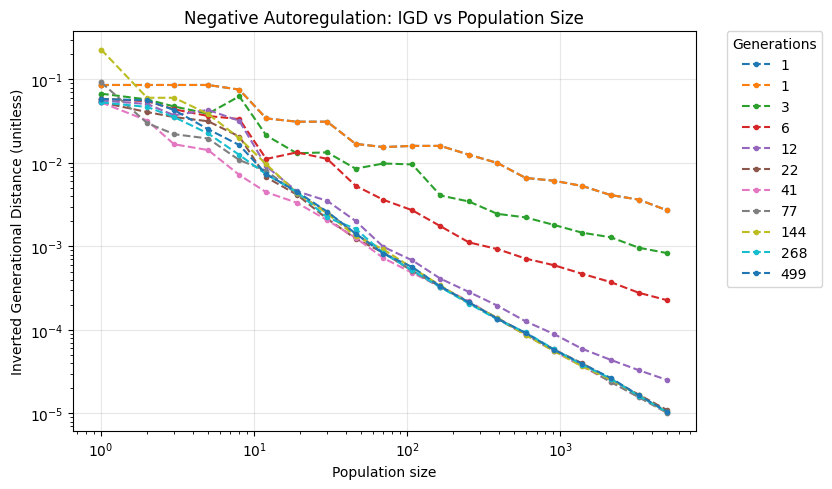

In [17]:
# --- Plot Generational Distance for each generation column ---
plt.figure(figsize=(10, 5))

# Loop over each column (generation)
for col, gens in enumerate(gens_list):
    plt.plot(
        popsize_list, 
        IGDs[:, col], 
        marker='.', 
        linestyle='--', 
        label=f'{gens}'
    )

plt.xlabel("Population size")
plt.ylabel("Inverted Generational Distance (unitless)")
plt.yscale('log')
plt.xscale('log')
plt.title("Negative Autoregulation: IGD vs Population Size")
plt.grid(alpha=0.3)

# --- Legend outside on the right ---
plt.legend(
    title="Generations",
    bbox_to_anchor=(1.05, 1),   # (x, y) position — push to the right
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for legend
plt.show()

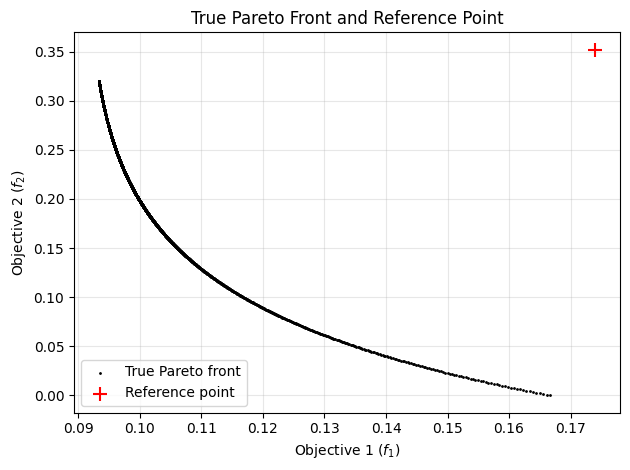

In [18]:
# --- Reference point based on true Pareto front (t) ---
buffer = 0.10  # 10% buffer beyond true front bounds
t_min = gridsearchdata.min(axis=0)
t_max = gridsearchdata.max(axis=0)
ref_point = t_max + buffer * (t_max - t_min)

plt.figure()

# --- True Pareto front ---
plt.scatter(
    gridsearchdata[:,0],
    gridsearchdata[:,1],
    color='black',
    label='True Pareto front',
    s=1,
    zorder=3
)

# --- Reference point ---
plt.scatter(
    ref_point[0],
    ref_point[1],
    color='red',
    marker='+',
    s=100,
    label='Reference point',
    zorder=4
)

plt.xlabel("Objective 1 ($f_1$)")
plt.ylabel("Objective 2 ($f_2$)")
plt.title("True Pareto Front and Reference Point")
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
hv = HV(ref_point=ref_point)
HV_true = float(hv(gridsearchdata))

# --- Initialize storage ---
HV_grid = np.full(Storage_EvolvingParetos_Popsize.shape, np.nan)
HV_ratio = np.full(Storage_EvolvingParetos_Popsize.shape, np.nan)

# --- Compute HV for each cell ---
for i in range(Storage_EvolvingParetos_Popsize.shape[0]):      # population
    for j in range(Storage_EvolvingParetos_Popsize.shape[1]):  # generations
        
        pf = Storage_EvolvingParetos_Popsize[i, j]
        if pf is None or len(pf) == 0:
            continue
        
        pf = np.asarray(pf, dtype=float)
        hv_val = float(hv(pf))
        HV_grid[i, j] = hv_val
        HV_ratio[i, j] = hv_val / HV_true if HV_true > 0 else np.nan

print("Reference point:", ref_point)
print(f"True front HV: {HV_true:.6f}")
print("HV grid shape:", HV_grid.shape)
print("HV ratio grid shape:", HV_ratio.shape)

Reference point: [0.17400091 0.35207516]
True front HV: 0.022346
HV grid shape: (21, 11)
HV ratio grid shape: (21, 11)


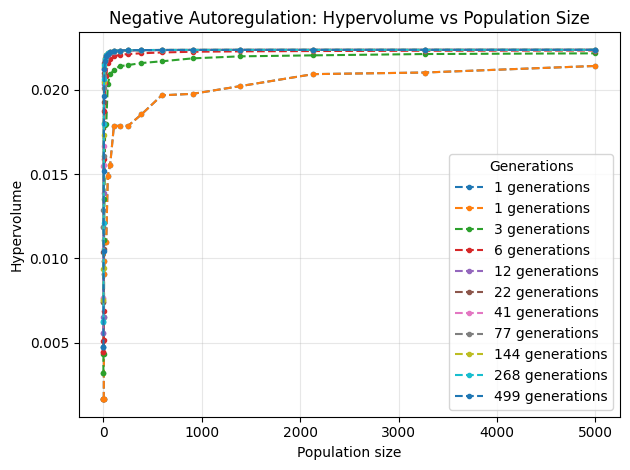

In [ ]:
# --- Plot Hypervolume for each generation column ---
plt.figure()

for col, gens in enumerate(gens_list):
    plt.plot(
        popsize_list,
        HV_grid[:, col],
        marker='.',
        linestyle='--',
        label=f'{gens} generations'
    )


# Add horizontal line for the true HV
plt.axhline(
    y=HV_true,
    color='red',
    linestyle='-',
    linewidth=2,
    label='True Pareto HV'
)

plt.xlabel("Population size")
plt.ylabel("Hypervolume")
# plt.xscale('log')
# plt.yscale('log')
plt.title("Negative Autoregulation: Hypervolume vs Population Size")
plt.legend(title="Generations", loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Analysis: evolving Pareto fronts with number of generations (row wise evolution)

In [21]:
# Create storage for evolving pareto fronts across population sizes for each generation
Storage_EvolvingParetos_Gens = np.empty((len(popsize_list), len(gens_list)), dtype=object)
Storage_EvolvingParams_Gens  = np.empty((len(popsize_list), len(gens_list)), dtype=object)

# Loop through population sizes row-wise
for rownum, popsize in enumerate(popsize_list):

    # Get the data for this generation across all population sizes
    Frow = all_F_np[rownum, :] 
    Xrow = all_X_np[rownum, :]

    # Row vectors to store sequence of Pareto front & parameter coordinates
    pareto_front_sequence = np.empty(Frow.size, dtype=object)
    pareto_param_sequence = np.empty(Xrow.size, dtype=object)

    # Loop through number of generations
    for columnnum, gens in enumerate(gens_list):
        
        # Initialize empty accumulators for this population size
        AllParetoFrontsUpToCurrentGen = np.empty((0, 2))  # Initialize an empty array
        AllParetoParamsUpToCurrentGen = np.empty((0, 2))  # Initialize an empty array

        # Accumulate data from the first run up to the current run
        for ind in range(columnnum + 1):

            CurrentParetoFront = Frow[ind]
            AllParetoFrontsUpToCurrentGen = np.vstack((AllParetoFrontsUpToCurrentGen, CurrentParetoFront))

            CurrentParetoParam = Xrow[ind]
            AllParetoParamsUpToCurrentGen = np.vstack((AllParetoParamsUpToCurrentGen, CurrentParetoParam))

        # Compute Pareto-optimal points
        mask = paretoset(AllParetoFrontsUpToCurrentGen, sense=["min", "min"])
        filteredfront = AllParetoFrontsUpToCurrentGen[mask]
        filteredparam = AllParetoParamsUpToCurrentGen[mask]

        # Store Pareto front and pareto parameters for this row
        pareto_front_sequence[columnnum] = filteredfront
        pareto_param_sequence[columnnum] = filteredparam

    # Store the full column sequence for this generation
    Storage_EvolvingParetos_Gens[rownum,:] = pareto_front_sequence
    Storage_EvolvingParams_Gens[rownum,:]  = pareto_param_sequence

In [23]:
# Compute Generational Distance (GD) grid across population × generation
IGDs = np.full(Storage_EvolvingParetos_Gens.shape, np.nan)  # prefill with NaN

# Define indicator once using the reference front
ind = IGD(gridsearchdata)

for col, gens in enumerate(gens_list):             # loop over generations
    for row, popsize in enumerate(popsize_list):   # loop over population sizes
        pf = Storage_EvolvingParetos_Popsize[row, col]  # get Pareto front
        IGDs[row, col] = ind(pf)        # evaluate vs reference front

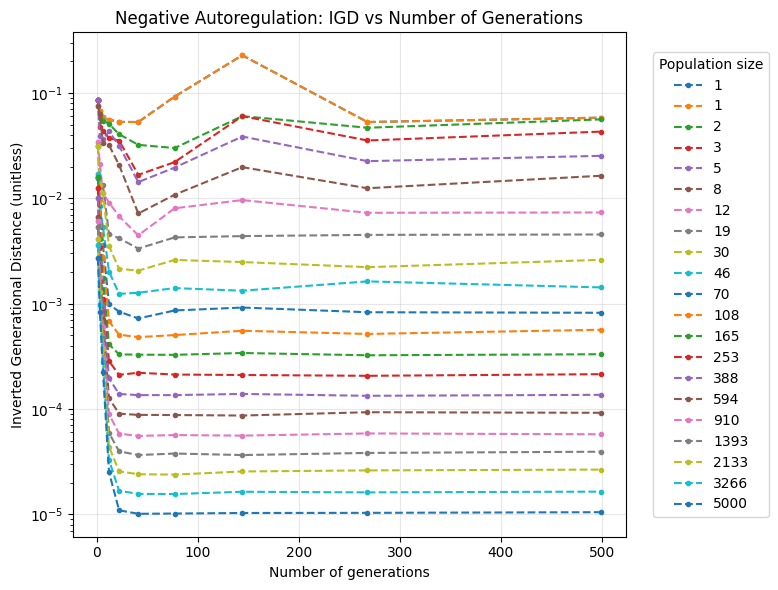

In [25]:
# --- Plot Inverted Generational Distance for each population size row ---
plt.figure(figsize=(10, 6))

# Loop over each population size (row)
for row, popsize in enumerate(popsize_list):
    plt.plot(
        gens_list, 
        IGDs[row, :], 
        marker='.', 
        linestyle='--', 
        label=f'{popsize}'
    )

plt.xlabel("Number of generations")
plt.ylabel("Inverted Generational Distance (unitless)")
plt.yscale('log')
plt.title("Negative Autoregulation: IGD vs Number of Generations")
plt.grid(alpha=0.3)

# Legend outside on the right
plt.legend(
    title="Population size",
    bbox_to_anchor=(1.05, 0.5),  # (x, y) position — 1.05 pushes it slightly outside the right edge
    loc='center left',           # anchor the left side of the legend box to that point
    borderaxespad=0.0
)

plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave space on the right for the legend
plt.show()

In [26]:
hv = HV(ref_point=ref_point)
HV_true = float(hv(gridsearchdata))

# --- Initialize storage ---
HV_grid = np.full(Storage_EvolvingParetos_Gens.shape, np.nan)
HV_ratio = np.full(Storage_EvolvingParetos_Gens.shape, np.nan)

# --- Compute HV for each cell ---
for i in range(Storage_EvolvingParetos_Gens.shape[0]):      # population
    for j in range(Storage_EvolvingParetos_Gens.shape[1]):  # generations
        
        pf = Storage_EvolvingParetos_Gens[i, j]
        if pf is None or len(pf) == 0:
            continue
        
        pf = np.asarray(pf, dtype=float)
        hv_val = float(hv(pf))
        HV_grid[i, j] = hv_val
        HV_ratio[i, j] = hv_val / HV_true if HV_true > 0 else np.nan

print("Reference point:", ref_point)
print(f"True front HV: {HV_true:.6f}")
print("HV grid shape:", HV_grid.shape)
print("HV ratio grid shape:", HV_ratio.shape)

Reference point: [0.17400091 0.35207516]
True front HV: 0.022346
HV grid shape: (21, 11)
HV ratio grid shape: (21, 11)


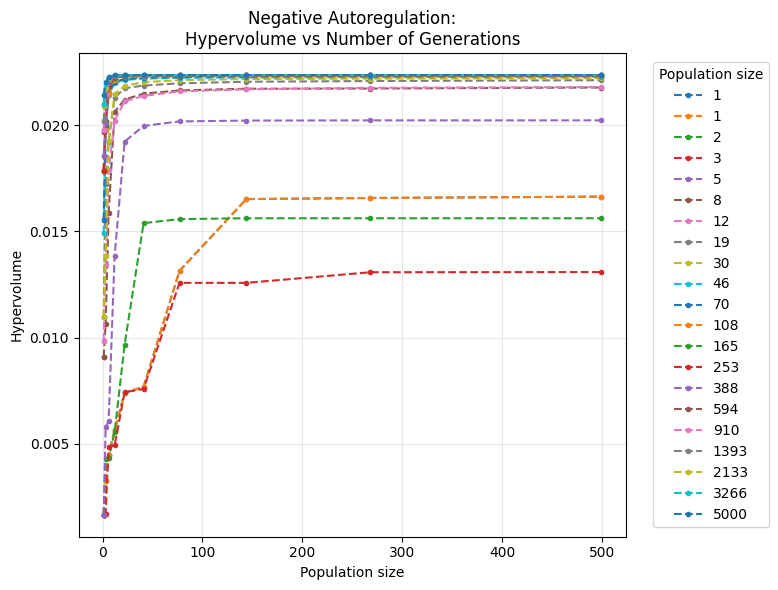

In [27]:
# --- Plot Hypervolume for each generation column ---
plt.figure(figsize=(10, 6))

for row, popsize in enumerate(popsize_list):
    plt.plot(
        gens_list,
        HV_grid[row, :],
        marker='.',
        linestyle='--',
        label=f'{popsize}'
    )

plt.xlabel("Population size")
plt.ylabel("Hypervolume")
plt.title("Negative Autoregulation:\nHypervolume vs Number of Generations")
plt.grid(alpha=0.3)

# Legend outside on the right
plt.legend(
    title="Population size",
    bbox_to_anchor=(1.05, 0.5),  # (x, y) position — 1.05 pushes it slightly outside the right edge
    loc='center left',           # anchor the left side of the legend box to that point
    borderaxespad=0.0
)

plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave space on the right for the legend
plt.show()